In [1]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3

<div class="alert alert-danger">

<b>Ce notebook est à remplir au fur et à mesure du cours et constituera votre rapport sur les trois premières journées de cours. Les questions entourées du symbole $\star$ sont à traiter en dehors du cours.</b></div>

<h1 class="text-center">EISC-211 : Méthodes de Monte-Carlo</h1>


<a id="SIMUSTO"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> III. Eléments de simulation stochastique et méthode du rejet</h1>


<div class="alert alert-success"> 

On présente ici des éléments de simulation stochastique. On discute d'abord de méthodes pour vérifier qu'une variable aléatoire suit une loi donnée, puis on présente la méthode du rejet, qui permet de générer une variable aléatoire avec une loi donnée. Une autre méthode classique et très importante est la méthode d'inversion de la fonction de répartition qui fait l'objet du DM.<br>
<br>
Nous verrons dans la suite du cours que la méthode du rejet est à la base de la technique d'échantillonnage préférentiel et des méthodes de Monte-Carlo à base de chaînes de Markov.<br>
<br>
<b>Rappel</b>. La fonction de répartition d'une variable aléatoire $X$, notée $F_X$, est la fonction $F_X(x) = P(X \leq x)$.
</div>



<h2> III.1. Histogramme et densité </h2>

Soit $X$ une variable aléatoire absolument continue que l'on sait générer mais dont on ne connaît pas la densité. Pour vérifier qu'une densité candidate $g$ est proche de la véritable densité, une manière très visuelle est de générer un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ et de comparer un histogramme associé à cet échantillon à $g$.



<p class="bg-primary" style="padding:1em">

<b>QUESTION III.1.1.</b> Soit $(Y_k)$ i.i.d. qui suivent une loi exponentielle de paramètre $1/2$. Le théorème central limite prédit que
$$ X = \sum_{k=1}^{100} Y_k $$
suit approximativement une loi normale : quels sont les paramètres de cette loi ?<br>

<div class="alert alert-warning">

<b>REPONSE A LA QUESTION III.1.1.</b> </div>
On calcule ses paramètres à partir de ceux de la variable aléatoire $\sum Y_k$. On a: 
$$\mathbb{E}(X_k) \underset{i.i.d}{=} 100 * \mathbb{E}(Y_1) = \boxed{200}$$
Et la variance d'une loi exponentielle étant $1/\lambda^2$ (et les variables sont i.i.d), on a $\boxed{\mathbb{V}(X) = 400}$ , soit $\sigma = 20$ </p>
<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.2.</b> Vérifiez votre réponse en complétant le script suivant, et commentez les résultats obtenus.</p>

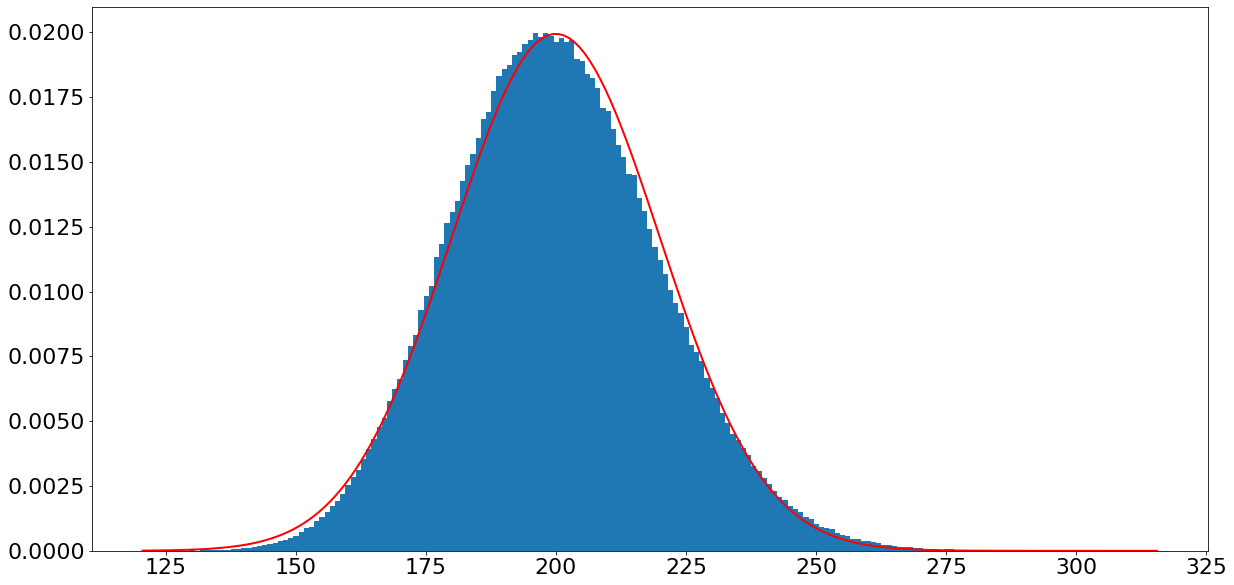

In [2]:
taille_echantillon = 10**6
nb_termes = 100
parametre_exp = .5
echantillon = np.sum(np.random.exponential(2,(taille_echantillon, 100)), axis=1)
count, bins, ignored = plt.hist(echantillon, np.arange(np.min(echantillon)-0.5, np.max(echantillon)+1.5), density=True)
mu = 200
sigma = 20
plt.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma), linewidth=2, color='r')

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.2.</b> </div>

La somme des variables tend bien vers une loi normale avec les bons paramètres.

---

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.3.</b> Discutez des limitations potentielles de cette méthode.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.3.</b> </div>

La moyenne et l'écart type sont liés, et donc on ne peut pas simuler directement toutes les lois normales.

---

<h2> III.2. Fonction de répartition empirique </h2>

Nous présentons maintenant une méthode plus rigoureuse. On considère un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ à valeurs dans $\mathbb{R}$ et on s'intéresse à la fonction
$$ \widehat F_N: x \in \mathbb{R} \mapsto \frac{1}{N} \sum_{k=1}^N {\bf 1}(X_k \leq x). $$


<p class="bg-primary" style="padding:1em">

<b>QUESTION III.2.1.</b> Montrez que $\widehat F_N(x) \to F_X(x)$ pour tout $x \in \mathbb{R}$ fixé.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.1.</b> </div>

Grâce à la loi des grands nombres, on a comme dans le notebook précédent que  $\widehat F_N(x)$ converge vers l'espérance de ${\bf 1}(X_k \leq x). $ , or l'espérance d'une indicatrice étant la probabilité de l'évènement qu'elle indique, on a bien que $\widehat F_N(x) \to F_X(x)$ pour tout $x \in \mathbb{R}$ fixé. 

---

La fonction $\widehat F_N$ est appelée **fonction de répartition empirique** de $X$. Pour vérifier qu'une variable aléatoire suit une loi de fonction de répartition $F$, on peut donc superposer $\widehat F_N$ et $F$ et accepter que $F = F_X$ si les deux courbes sont proches pour $N$ suffisamment grand.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.2.</b> Exécutez le script suivant pour vérifier que les fonctions utilisées simulent bien des variables aléatoires de lois exponentielle, gamma, uniforme et de Poisson. À partir de quelle taille d'échantillon les approximations vous semblent-elles valides ?</p>

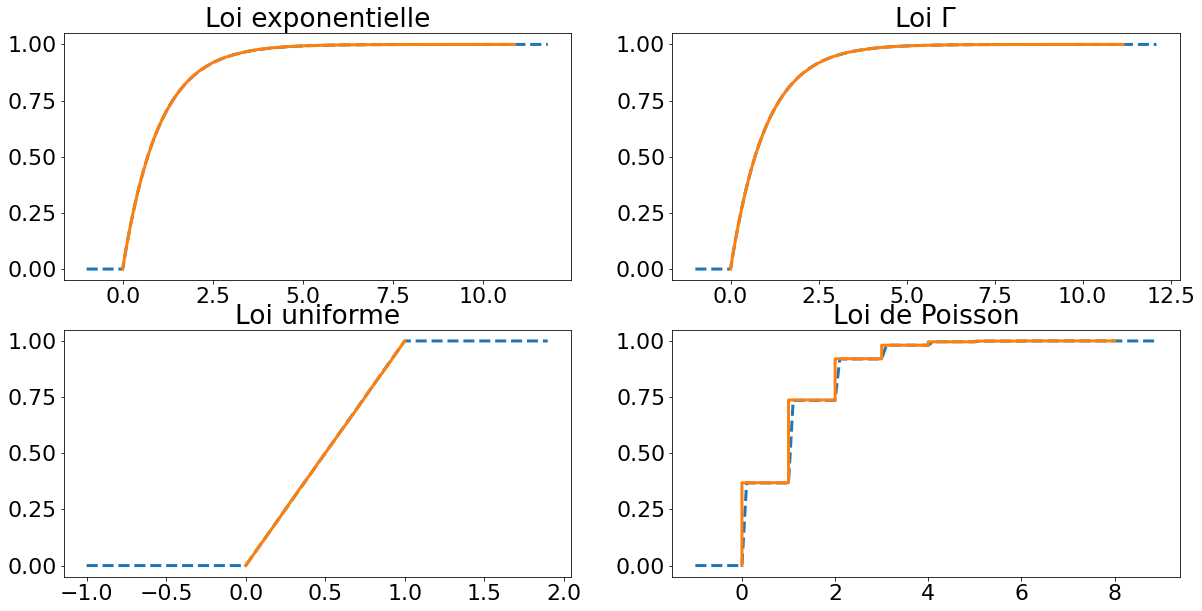

In [3]:
taille = 10**5

fig, ax = plt.subplots(2, 2)

# Loi exponentielle
a = ax[0,0]
a.set_title("Loi exponentielle")
echantillon = np.random.exponential(1.0, size=taille)
x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
a.plot(x, stats.expon.cdf(x), '--')
a.step(np.sort(echantillon), np.arange(taille) / taille, '-')

# Loi gamma
a = ax[0,1]
a.set_title(r"Loi $\Gamma$")
echantillon = np.random.gamma(1.0, size=taille)
x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
a.plot(x, stats.gamma.cdf(x, a=1.0), '--')
a.step(np.sort(echantillon), np.arange(taille) / taille, '-')

# Loi uniforme
a = ax[1,0]
a.set_title("Loi uniforme")
echantillon = np.random.uniform(size=taille)
x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
a.plot(x, stats.uniform.cdf(x), '--')
a.step(np.sort(echantillon), np.arange(taille) / taille, '-')

# Loi de Poisson
a = ax[1,1]
a.set_title("Loi de Poisson")
echantillon = np.random.poisson(size=taille)
x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
a.plot(x, stats.poisson.cdf(x, mu=1.0), '--')
a.step(np.sort(echantillon), np.arange(taille) / taille, '-')

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.2.</b> </div>

Dès $10^3$ toute les lois sont bien simulées, sauf la loi de Poisson qui est un peu mieux simulé avec $10^4$ échantillon.

<p class="bg-primary" style="padding:1em">

<b>QUESTION III.2.3.</b> Soient $U_1$, $U_2$ indépendantes et uniformément réparties sur $[0,1]$ et $Z = \sqrt{- 2 \ln U_1} \cos(2 \pi U_2)$. Vous pouvez générer au plus 200 variables aléatoires. Parmi les choix suivants, quelle est selon vous la loi de $Z$?
<br>

&#9679; Cauchy, i.e., $f_Z(z) \propto 1/(1+z^2)$ (cf. ``stats.cauchy``)

<br>

&#9679; Laplace, i.e., $f_Z(z) \propto e^{-\lvert z \rvert}$ (cf. ``stats.laplace``)

<br>

&#9679; Gauss, i.e., $f_Z(z) \propto e^{-z^2/2}$ (cf. ``stats.norm``)</p>

(200,)
(144,)


Text(0.5, 0.98, 'Title')

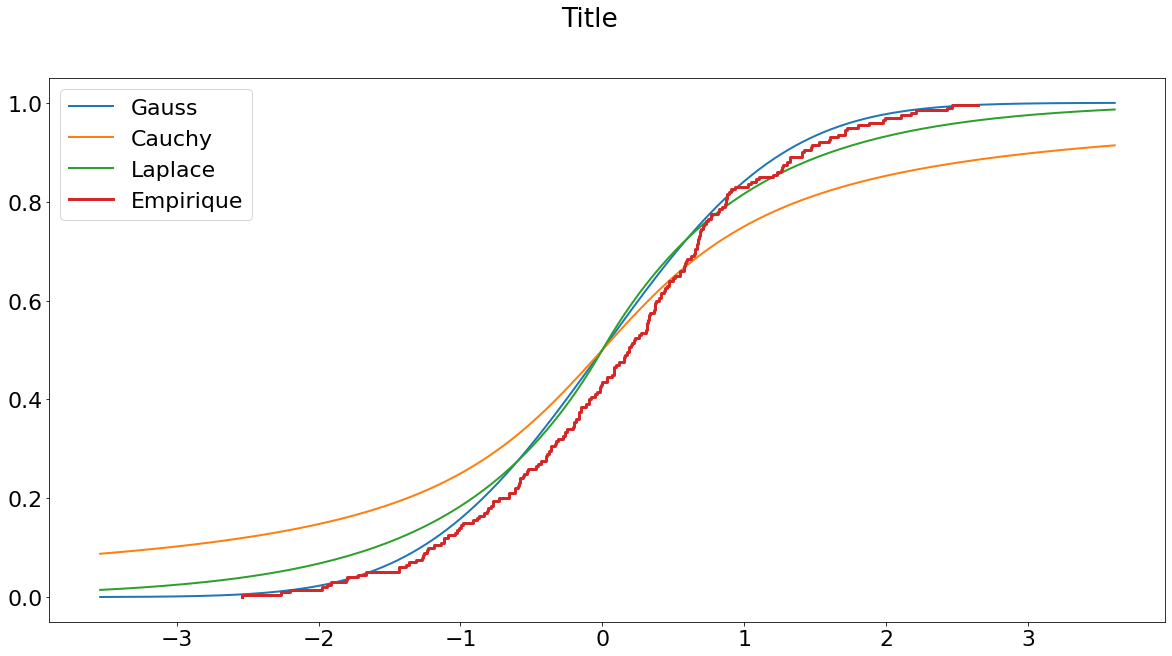

In [4]:
taille = 200
u1 = np.random.random_sample(taille)
u2 = np.random.random_sample(taille) 
z  = np.sqrt(-2*np.log(u1)) * np.cos(2*np.pi*u2)
print(z.shape)
s = np.arange(np.min(z)-1, np.max(z)+1,.05)
print(s.shape)
plt.plot(s, stats.norm.cdf(s), linewidth=2, label="Gauss")
plt.plot(s, stats.cauchy.cdf(s), linewidth=2, label="Cauchy")
plt.plot(s, stats.laplace.cdf(s), linewidth=2, label="Laplace")
plt.step(np.sort(z), np.arange(taille) / taille, label="Empirique")
plt.legend()
plt.suptitle("Title")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.3.</b> </div>

Vu l'allure de la courbe, Z semble suivre une loi normale.

---

Jusqu'à présent, la méthode proposée n'est pas beaucoup plus rigoureuse que l'utilisation des histogrammes, à la différence qu'il n'y a pas besoin de faire de choix pour les urnes. Un autre avantage est que la vitesse de convergence $\widehat F_N \to F_X$ peut être quantifiée comme on le voit maintenant.

<p class="bg-primary" style="padding:1em">

<b>$\star$ QUESTION III.2.4. $\star$</b> Quel résultat contrôle les fluctuations de $\widehat F_N(x)$ autour de $F_X(x)$? Montrez que
$$ P \left( \widehat F_N(x) - \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95 \ \text{ où } \ \varepsilon_N(x) = \frac{\sigma(x) F^{-1}(0{,}975)}{\sqrt N} $$
avec $\sigma(x)^2 = F_X(x) (1-F_X(x))$, $F$ la fonction de répartition de la loi normale centrée réduite et $F^{-1}$ son inverse.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.4.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>$\star$ QUESTION III.2.5. $\star$</b> Quel est le problème de la fonction $\varepsilon_N$? Proposez une fonction $\widehat \varepsilon_N$ sans ce problème et qui satisfait aussi
$$ P \left( \widehat F_N(x) - \widehat \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \widehat \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0.95. $$

</p>

<div class="alert alert-warning">

<b>REPONSE A LA QUESTION III.2.5.</b> </div>

On remarquera en particulier que $[\widehat F_N(x) - \widehat \varepsilon_N(x), \widehat F_N(x) + \widehat \varepsilon_N(x)]$ est un **intervalle de confiance bilatéral symétrique** de $F_X(x)$ au niveau asymptotique $95\%$.

<p class="bg-primary" style="padding:1em">

<b>$\star$ QUESTION III.2.6. $\star$</b> Reprenez et complétez le script de la question III.2.2 pour ajouter les deux enveloppes $\widehat F_{100} \pm \widehat \varepsilon_{100}$. Utilisez pour cela les fonctions <code>np.std</code> et <code>stats.norm.ppf</code>.</p>

In [46]:
# TO DO

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.6.</b> </div>

<h2> III.3. Méthode du rejet </h2>


Soit $Y$ une variable aléatoire absolument continue admettant pour densité $f$ satisfaisant $f(x) = 0$ si $\lvert x \rvert \geq 1$ et $\sup f < \infty$. On génère itérativement des points uniformément répartis sur $[-1,1] \times [0,K]$ avec $K \geq 2\sup f$ jusqu'à avoir généré un point sous la courbe $f$. Sur la figure ci-dessous, on a généré les quatre croix avant de générer le point noir.

![title](rejet.png)



On considère alors l'abscisse du premier point sous la courbe, que l'on note $Z$. Dans le deuxième devoir maison, vous montrerez que
$$ \tag{1} P(Z \leq z) = P(X \leq z \mid U \leq f(X)), \ z \in \mathbb{R}, $$
avec $(X, U)$ uniformément réparti sur $[-1,1] \times [0,K]$.

<p class="bg-primary" style="padding:1em">

<b>QUESTION III.3.1.</b> Donnez la densité de $(X, U)$ et déduisez de (1) que $Z$ admet $f$ pour densité.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.1.</b> </div>

On a : $$f_{X,U}(x,y)= \frac{\textbf{1} \{ [-1, 1]\}(x) \cdot \textbf{1} \{ [0,K]\}(y)}{2K}$$

On a : $$P(Z \leq z) = P(X \leq Z | U \leq f(X)) = \frac{P(X \leq z, U \leq f(X))}{P(U \leq f(X))} \overset{\text{def}}{=} \frac{p_1}{p_2}$$
On calcule donc chacun des membres, mais d'abord, calculons $P(U \leq f(x) |X = x)$ pour tout $x \in [-1,1]$.
$$P( U \leq f(x) | X = x) = \int\limits_{t = 0}^{f(x)} \frac{f_{X,U}(x,t)}{f_X(x)} \text{d}t = \int\limits_{t=0}^{f(x)} \frac{ \displaystyle \frac{1}{2K} \overbrace{\textbf{1}\{ [-1,1]\}(x)}^{1} \overbrace{\textbf{1} \{ [0,K]\}(t)}^{1 \; (t \leq f(x) \leq K)} }{\displaystyle \frac{1}{2} \underbrace{\textbf{1}\{ [-1,1]\}(x)}_{1} } \text{d}t = \int\limits_{t=0}^{f(x)} \frac{\text{d}t}{K} = \frac{f(x)}{K}$$

On peut maintenant calculer les deux termes

$$p_1 = P(X \leq z, U \leq f(X)) = \int\limits_{x=-1}^z P(U \leq f(x) | X = x) \text{d}x = \int\limits_{x=-1}^z \frac{f(x)}{K} \text{d}x$$
$$p_2 = P(U \leq f(X)) = \int\limits_{x=-1}^1 P(U \leq f(x) | X = x) \text{d}x = \int\limits_{x=-1}^1 \frac{f(x)}{K} \text{d}x = \frac{1}{K}$$
Ainsi on a $\displaystyle \frac{p_1}{p_2} = P(Z \leq z) = \int\limits_{x=-1}^z f(x) \text{d}x$ et ce pour tout $z$. <br>
Ce qui confirme bien que $f$ est la densité de probabilité associée à $Z$.

---



<p class="bg-primary" style="padding:1em">

<b>QUESTION III.3.2.</b> Quelle est la loi du nombre de points rejetés avant d'en accepter un? Précisez la valeur du paramètre de cette loi. En déduire le nombre moyen de simulations nécessaires afin de simuler $Y$ selon cette méthode.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.2.</b> </div>

D'après le calcul du dessus, la probabilité d'accepter un point est $1/K$, c'est une expérience de Bernoulli que l'on répète, donc la probabilité du premier succès suit une loi géométrique de paramètre $1/K$, et son espérance est donc $K$.

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION III.3.3.</b> Ecrivez un script qui implante cette méthode dans le cas où $f$ est la densité normale tronquée, i.e.,
$$ f(x) \propto \exp\left( -\frac{x^2}{2} \right) {\bf 1}(-1 \leq x \leq 1). $$
Vous vérifierez bien que la sortie de votre script admet la bonne loi.</p>

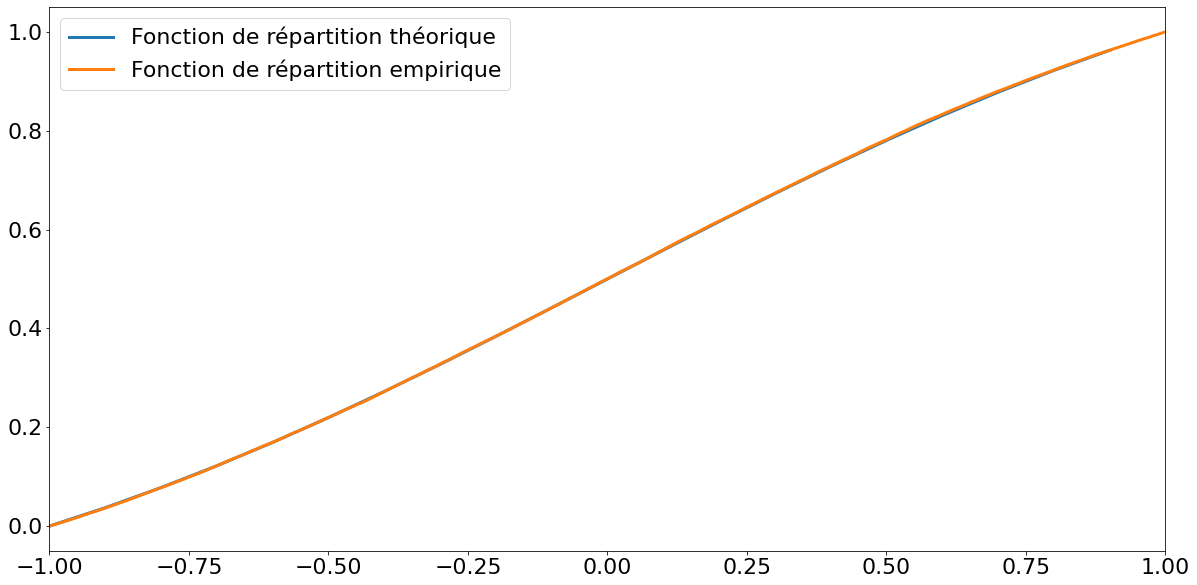

In [5]:
taille = 10**5
s = np.arange(-1,1,.1)
f = lambda x : np.exp(- x**2 / 2)
K = 2 # Need K >= 2


echantillon = []
for i in range(taille) :
    x = np.random.random_sample() * 2 - 1
    u = np.random.random_sample() * K
    while f(x) < u  :
        x = np.random.random_sample() * 2 - 1
        u = np.random.random_sample() * K
    echantillon.append(x)

plt.plot(s, stats.truncnorm.cdf(s,-1,1), label= "Fonction de répartition théorique")
plt.step(np.sort(echantillon), np.arange(taille) / taille, label= "Fonction de répartition empirique")
plt.xlim(left=-1,right=1)
plt.legend()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.3.</b> </div>

La méthode fonctionne bien.

<p class="bg-primary" style="padding:1em">

<b>QUESTION III.3.4.</b> A l'aide de la méthode du rejet, écrivez un code qui permet de générer une variable aléatoire de densité $\displaystyle f(x) \propto \lvert x \rvert \exp(\lvert x \rvert^\pi) {\bf 1}(\lvert x \rvert < 1)$. Le code suivant vous permet de calculer la constante de normalisation.</p>

In [6]:
from scipy.integrate import quad
f = lambda x : np.abs(x)*np.exp(np.abs(x)**np.pi)

cst = quad(f, -1, 1)[0]

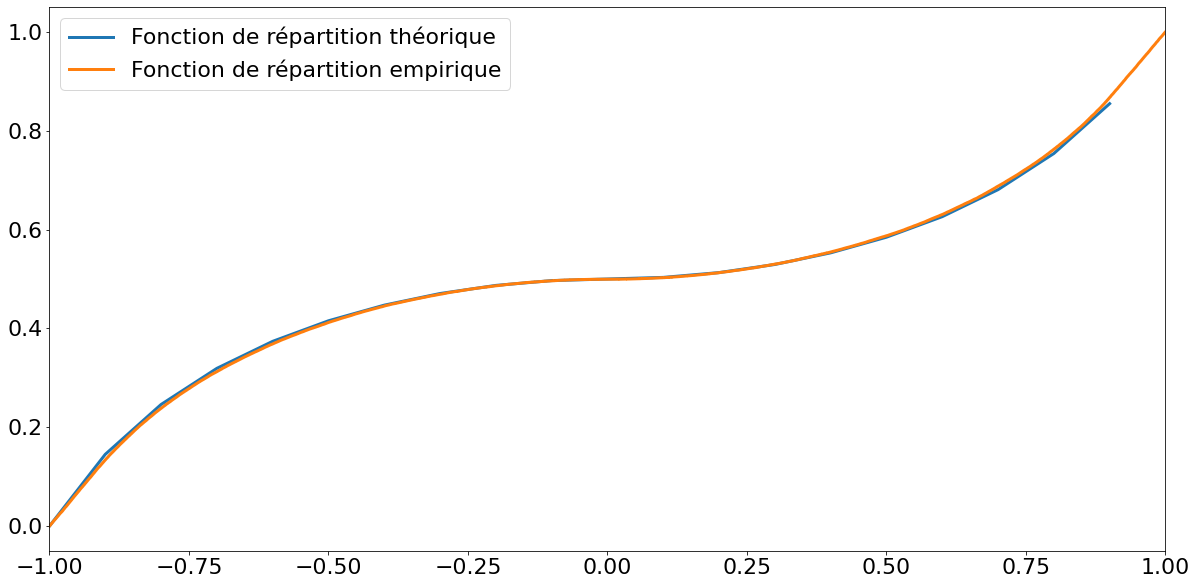

In [7]:
echantillon = []
for i in range(taille) :
    x = np.random.random_sample() * 2 - 1
    u = np.random.random_sample() * K
    while f(x) < u  :
        x = np.random.random_sample() * 2 - 1
        u = np.random.random_sample() * K
    echantillon.append(x)

th_curve = []
for s_ in s :    
    th_curve.append(quad(f, -1, s_)[0])

th_curve = np.array(th_curve)/cst
plt.plot(s, th_curve, label= "Fonction de répartition théorique")
plt.step(np.sort(echantillon), np.arange(taille) / taille, label= "Fonction de répartition empirique")
plt.xlim(left=-1,right=1)
plt.legend()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.4.</b> </div>

Cela fonctionne aussi.